In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

We first unzip the zip file to get all text files.

In [ ]:
!unzip final_data.zip

In [ ]:
def read_all():
  # This function will read all text files into pandas DataFrame.
  # And then store them into a list.
  l = list()
  for i in range(1,21635):
    k='x_all/'+str(i)+'.txt'
    p = pd.read_csv(k)
    l.append(p)
  return l

In [ ]:
def get_uniq_col(x):
  # This function will get all variables' names.
  uniq = set()
  for df in x:
    uniq.update(df.loc[:,'Variable'])
  return uniq

In [ ]:
train_io = pd.read_csv('train_outcome.csv')
test_index = pd.read_csv('test_nolabel.csv')
train_index = train_io["ID"]-1
y_train = train_io["Outcome"]
test_index = test_index["ID"]-1

In [ ]:
all_patients = read_all()
col_name = get_uniq_col(all_patients)
column_names = list(col_name)

Method 1: Boosting tree (With limited prediction variables)
\
Here we selected several lab values that may be very important for diagnosis

In [ ]:
def extract(x):
  p=pd.read_csv(x)
  hour = max(p['Hour'])
  lactate = np.mean(p["Variable"]=="Lactate")
  fio2 = np.mean(p["Variable"]=="FiO2")
  paco2 = np.mean(p["Variable"]=="PaCO2")
  #### paco2/fio2?
  creatinine = np.mean(p["Variable"]=="Creatinine")
  bilirubin = np.mean(p["Variable"]=="Bilirubin_direct")
  serum_glucose = np.mean(p["Variable"]=="Glucose")
  return pd.DataFrame({"Hour":[hour], 
                      "lactate":[lactate], 
                      "fio2":[fio2], 
                      "paco2":[paco2], 
                      "creatinine":[creatinine], 
                      "bilirubin":[bilirubin],
                      "serum_glucose": [serum_glucose]})
  

In [ ]:
def generate():
  n = 21634 # The number of patients
  df = pd.DataFrame(columns=["Hour", "lactate", "fio2", "paco2", "creatinine", "bilirubin", "serum_glucose"])#Add column names here
  for i in range(1,n+1):
    k='x_all/'+str(i)+'.txt'
    p = extract(k)
    df = df.append(p,ignore_index = True)
  return df

In [ ]:
df = generate()

In [ ]:
X_train_1 = df.iloc[train_index,]
X_test_1 = df.iloc[test_index,]


Now we begin to deal with missing value:

In [ ]:
imp = IterativeImputer(max_iter=10, random_state=123,missing_values=0)
X_train_1 = pd.DataFrame(imp.fit_transform(X_train_1),columns=["Hour", "lactate", "fio2", "paco2", "creatinine", "bilirubin", "serum_glucose"])
X_test_1 = pd.DataFrame(imp.transform(X_test_1),columns=["Hour", "lactate", "fio2", "paco2", "creatinine", "bilirubin", "serum_glucose"])

In [ ]:
train_1 = pd.concat([X_train_1, y_train], axis=1)

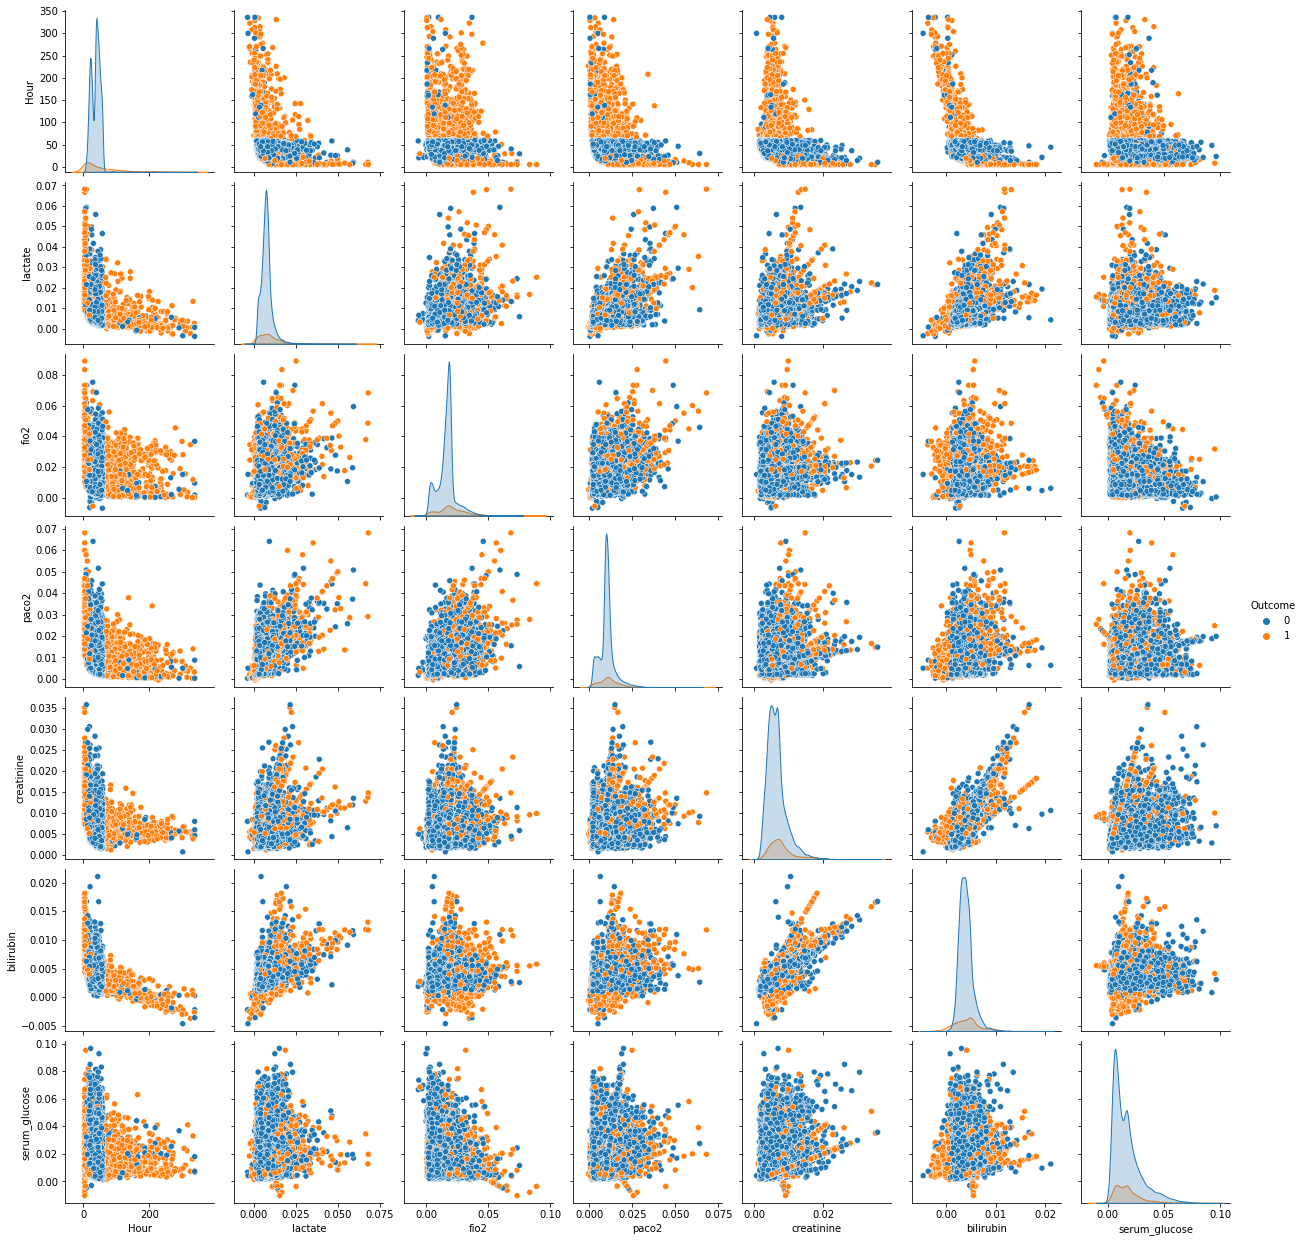

In [ ]:
sns.pairplot(train_1,hue='Outcome')

In [ ]:
train_1, val_1 = train_test_split(train_1, test_size = 0.2, random_state= 123)
X_train_1 = train_1.iloc[:,0:7]
y_train_1 = train_1.iloc[:,7]
X_val_1 = val_1.iloc[:,0:7]
y_val_1 = val_1.iloc[:,7]

In [ ]:
dtrain_1 = xgb.DMatrix(X_train_1, label=y_train_1)
dtest_1 = xgb.DMatrix(val_1.iloc[:,0:7], label=val_1.iloc[:,7])
param = {'max_depth': 3, 'eta': 0.3, 'objective': 'binary:logistic'}
param['nthread'] = 5
param['eval_metric'] = 'auc'
param['scale_pos_weight'] = np.sum(y_train==0)/np.sum(y_train==1)
evallist = [(dtrain_1, 'train'), (dtest_1, 'eval')]
num_round = 25
bst = xgb.train(param, dtrain_1, num_round, evallist)
y_pred = bst.predict(dtest_1)
k = np.array(y_val_1)
y_p = np.array([1 if i > 0.5 else 0 for i in y_pred])
print(np.mean(y_p==k))
print(metrics.balanced_accuracy_score(y_val_1, y_p))
print(metrics.roc_auc_score(y_val_1, y_pred))

[0]	train-auc:0.85320	eval-auc:0.86479
[1]	train-auc:0.85570	eval-auc:0.87063
[2]	train-auc:0.86741	eval-auc:0.87606
[3]	train-auc:0.88444	eval-auc:0.88394
[4]	train-auc:0.88513	eval-auc:0.88446
[5]	train-auc:0.89155	eval-auc:0.88903
[6]	train-auc:0.89267	eval-auc:0.89012
[7]	train-auc:0.89542	eval-auc:0.89163
[8]	train-auc:0.90040	eval-auc:0.89682
[9]	train-auc:0.89977	eval-auc:0.89464
[10]	train-auc:0.90184	eval-auc:0.89575
[11]	train-auc:0.90200	eval-auc:0.89594


/usr/local/lib/python3.9/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[12]	train-auc:0.90544	eval-auc:0.89736
[13]	train-auc:0.90688	eval-auc:0.89857
[14]	train-auc:0.90956	eval-auc:0.89940
[15]	train-auc:0.91002	eval-auc:0.89966
[16]	train-auc:0.91055	eval-auc:0.89980
[17]	train-auc:0.91167	eval-auc:0.89970
[18]	train-auc:0.91138	eval-auc:0.89979
[19]	train-auc:0.91253	eval-auc:0.89996
[20]	train-auc:0.91422	eval-auc:0.89954
[21]	train-auc:0.91445	eval-auc:0.90000
[22]	train-auc:0.91566	eval-auc:0.90011
[23]	train-auc:0.91838	eval-auc:0.90208
[24]	train-auc:0.92011	eval-auc:0.90207
0.8956751403103335
0.8465405787129251
0.902066961213921


This model has a balanced accuracy equals 0.847, auc equals 0.902. This model has a excellent performance on prediction.

In [ ]:
xgb.cv(param, dtrain_1, num_round, nfold=10,
       metrics={'auc'}, seed=0,
       callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)])

:The 7 features gradient boosting model seems to deliver a good result, now we introduce more features in the gradient boosting model.

In [ ]:
def generate2(column_names):
  # This function generate the mean of all variables for every patient.
  # It outputs a 2D pandas DataFrame in which each row represents a patient.
  n = 21634 # The number of patients
  df = pd.DataFrame(columns=column_names)#Add column names here
  for i in range(1,n+1):
    p = all_patients[i-1]
    d = pd.DataFrame(p.groupby('Variable')['Value'].mean())
    df = df.append(d.T,ignore_index = True)
    df.loc[i-1,'time'] = max(p['Hour'])
  return df

In [ ]:
def generatemax():
  # This function generate the max value of all variables.
  n = 21634 # The number of patients
  df = pd.DataFrame()#Add column names here
  for i in range(1,n+1):
    p = all_patients[i-1]
    d = pd.DataFrame(p.groupby('Variable')['Value'].max())
    df = df.append(d.T,ignore_index = True)
  return df
def generatemin():
  # This function generate the min value of all variables
  n = 21634 # The number of patients
  df = pd.DataFrame()#Add column names here
  for i in range(1,n+1):
    p = all_patients[i-1]
    d = pd.DataFrame(p.groupby('Variable')['Value'].min())
    df = df.append(d.T,ignore_index = True)
  return df

Now we generate the design matrix for our model. The features are the mean, min, and max value of all variables for every patient.

In [ ]:
df1 = generate2(column_names.append("time"))
df2 = generatemax()
df3 = generatemin()
df = pd.concat([df1, df2, df3], axis = 1)

Here I dropped out several columns that are clearly unrelated to the diagnosis, among them are Unit1, Unit2, and ID. Also we delete some columns that the min, max, and mean should be the same, e.g. Age, and Gender.

In [ ]:
df = df.drop(columns = ["Unit1", "Unit2", "ID"])
cols_to_drop = df.columns.duplicated() & (df.columns.str.startswith('Age') |
                                          df.columns.str.startswith('Gender'))
df = df.loc[:,~cols_to_drop]

In [ ]:
col = df.columns.tolist()
X_train_full = df.iloc[train_index,]
X_test_full = df.iloc[test_index,]

Now let's look at the design matrix. 

In [ ]:
X_train_full.head(5)

Variable,Age,BUN,Creatinine,DBP,Gender,HR,Hct,Hgb,MAP,Magnesium,...,Calcium,Fibrinogen,Lactate,PTT,TroponinI,AST,Alkalinephos,Bilirubin_total,EtCO2,Bilirubin_direct
1,66.67,12.035000,0.700000,58.804000,1.0,89.924500,27.417500,9.130000,75.333000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,79.74,10.190000,0.566667,55.344848,0.0,83.729600,30.742500,10.563750,75.293269,2.564,...,8.21,161.19,0.88,23.81,NaN,NaN,NaN,NaN,NaN,NaN
3,35.18,NaN,0.750000,78.196944,1.0,107.003939,42.500000,14.200000,104.096286,NaN,...,9.30,NaN,NaN,NaN,0.07,NaN,NaN,NaN,NaN,NaN
4,60.74,12.291667,0.703333,75.085207,1.0,74.814603,42.238333,14.018333,99.515625,1.890,...,0.93,NaN,0.66,29.58,0.01,36.00,58.00,1.3,25.1,NaN
5,77.32,26.415000,0.465000,NaN,0.0,61.970244,29.576667,9.690000,80.990000,2.185,...,8.02,611.00,NaN,33.73,NaN,23.91,70.18,0.3,NaN,NaN


The summary statistics of each prediction variable:

In [ ]:
X_train_full.describe()

Variable,Age,BUN,Creatinine,DBP,Gender,HR,Hct,Hgb,MAP,Magnesium,...,Calcium,Fibrinogen,Lactate,PTT,TroponinI,AST,Alkalinephos,Bilirubin_total,EtCO2,Bilirubin_direct
count,15144.000000,13893.000000,13816.000000,12227.000000,15144.000000,15136.000000,13840.000000,13720.000000,15100.000000,12831.000000,...,12582.000000,1392.000000,4284.000000,6660.000000,2254.000000,4784.000000,4715.000000,4701.000000,1153.000000,648.000000
mean,61.615115,22.299924,1.429828,63.919722,0.568212,84.237467,31.892845,10.676119,82.346391,2.029862,...,7.504998,297.166803,1.724659,33.214635,4.733026,113.915997,94.513962,1.366022,28.727901,1.468580
std,16.435411,18.284962,1.749610,11.009011,0.495342,14.994261,5.420410,1.895520,12.730022,0.329432,...,2.326294,173.822683,1.506128,16.796113,16.854888,420.934503,109.622814,2.838154,11.499157,3.252324
min,13.770000,1.000000,0.100000,28.320000,0.000000,33.282174,10.265000,3.327500,33.187200,0.500000,...,0.200000,27.090000,0.220000,17.200000,-1.050000,-286.850000,6.880000,0.080000,4.480000,0.010000
25%,51.190000,11.505000,0.700000,56.260623,0.000000,73.472714,28.008583,9.314750,73.271963,1.835000,...,7.600000,178.692500,1.000000,26.185000,0.030000,20.000000,52.210000,0.500000,22.810000,0.200000
50%,63.325000,16.555000,0.905000,62.804516,1.000000,83.499417,31.340000,10.500000,80.685946,2.000000,...,8.190000,250.500000,1.350000,29.400000,0.115000,32.465000,70.000000,0.700000,28.450000,0.400000
75%,73.970000,26.000000,1.310000,70.471090,1.000000,93.939286,35.348500,11.900000,89.674599,2.195000,...,8.610000,364.057500,1.900000,34.100000,1.387500,65.520000,100.000000,1.200000,33.930000,1.145000
max,100.990000,225.626667,27.065000,135.675556,1.000000,174.076410,65.000000,23.495000,170.980000,8.200000,...,23.700000,1383.000000,26.900000,250.000000,226.780000,9869.010000,3616.850000,40.690000,100.000000,37.500000


The number of NA values for each column:

In [ ]:
df.isnull().sum()

Variable
Age                     0
BUN                  1780
Creatinine           1861
DBP                  4137
Gender                  0
                    ...  
AST                 14881
Alkalinephos        14981
Bilirubin_total     14978
EtCO2               19946
Bilirubin_direct    20695
Length: 105, dtype: int64

In [ ]:
train.loc[:,["Gender","Age","Outcome"]]

,Gender,Age,Outcome
0,1.0,66.67,0
1,0.0,79.74,0
2,1.0,35.18,0
3,1.0,60.74,1
4,0.0,77.32,0
...,...,...,...
15139,1.0,61.44,0
15140,0.0,63.82,0
15141,1.0,65.41,0
15142,1.0,58.61,1


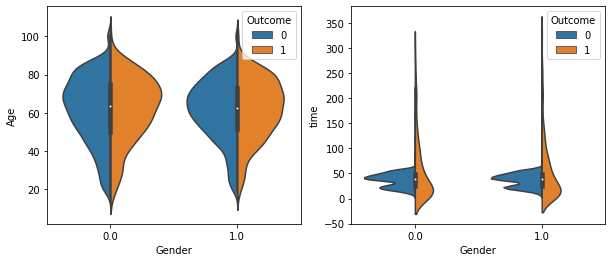

In [ ]:
f,ax=plt.subplots(1,2,figsize=(10,4))
sns.violinplot(x="Gender",y="Age", hue="Outcome", data=train.loc[:,["Gender","Age","Outcome"]],split=True,ax = ax[0])
sns.violinplot(x="Gender",y="time", hue="Outcome", data=train.loc[:,["Gender","time","Outcome"]],split=True,ax = ax[1])
plt.show()

There are some differences in Age between sepsis or no sepsis among the females.

This plot shows that The time in ICU has a significant effect in whether the patient has sepsis. This plot shows that, If the time length of the patient in ICU is very short or very long, then the patient has a significantly higher possibility of having a sepsis no matter what the gender is.

We applied iterative imputation to delete all NA values.

In [ ]:
imp = IterativeImputer(max_iter=10, random_state=123)
X_train_full = pd.DataFrame(imp.fit_transform(X_train_full),columns=col)
X_test = pd.DataFrame(imp.transform(X_test_full),columns=col)

/usr/local/lib/python3.9/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
train = pd.concat([X_train_full, y_train], axis=1)

In [ ]:
#partial_train = train.loc[:,['time','WBC','Temp','O2Sat','FiO2','Hgb','HR','Lactate','Potassium','Outcome']]

In [ ]:
train, val = train_test_split(train, test_size = 0.2, random_state= 166)
X_train = train.iloc[:,0:105]
y_train = train.iloc[:,105]
X_val = val.iloc[:,0:105]
y_val = val.iloc[:,105]

In [ ]:
column = X_train.columns
column_list = list()
for i in column:
  column_list.append(i)

In [ ]:
X_train.columns = [np.array(range(1,106))]
X_train_full.columns = [np.array(range(1,106))]
X_test.columns = [np.array(range(1,106))]
X_val.columns = [np.array(range(1,106))]

In [ ]:
#pca = PCA(n_components=3)
#pca.fit(X_train)
#X_train_st=pca.transform(X_train)
#X_val_st=pca.transform(X_val)

The model below is my final model.

In [ ]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_val, label=y_val)
param = {'max_depth': 3, 'eta': 0.267, 'objective': 'binary:logistic'}
param['min_child_weight'] = 5
param['alpha'] = 0
param['lambda'] = 1
#param['gamma'] = 1
#param['tree_method'] = 'hist'
#param['subsample'] = 1
#param['colsample_bytree'] = 1
param['eval_metric'] = 'auc'
param['scale_pos_weight'] = np.sum(y_train==0)/np.sum(y_train==1)
evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 23
bst = xgb.train(param, dtrain, num_round, evallist)
y_pred = bst.predict(dtest)
k = np.array(y_val)
y_p = np.array([1 if i >= 0.5 else 0 for i in y_pred])
print(np.mean(y_p==k))
print(metrics.roc_auc_score(np.array(y_val),y_pred))
print(metrics.balanced_accuracy_score(np.array(y_val),y_p))

/usr/local/lib/python3.9/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-auc:0.84307	eval-auc:0.84811
[1]	train-auc:0.87159	eval-auc:0.88512
[2]	train-auc:0.88614	eval-auc:0.88841
[3]	train-auc:0.89102	eval-auc:0.88861
[4]	train-auc:0.90278	eval-auc:0.90087
[5]	train-auc:0.90497	eval-auc:0.90576
[6]	train-auc:0.91162	eval-auc:0.90977
[7]	train-auc:0.91836	eval-auc:0.91059
[8]	train-auc:0.92247	eval-auc:0.91376
[9]	train-auc:0.92309	eval-auc:0.91439
[10]	train-auc:0.92610	eval-auc:0.91698
[11]	train-auc:0.92900	eval-auc:0.91948
[12]	train-auc:0.93168	eval-auc:0.92285
[13]	train-auc:0.93347	eval-auc:0.92234
[14]	train-auc:0.93423	eval-auc:0.92173
[15]	train-auc:0.93691	eval-auc:0.92217
[16]	train-auc:0.93894	eval-auc:0.92229
[17]	train-auc:0.93914	eval-auc:0.92264
[18]	train-auc:0.94125	eval-auc:0.92319
[19]	train-auc:0.94250	eval-auc:0.92247
[20]	train-auc:0.94441	eval-auc:0.92338
[21]	train-auc:0.94466	eval-auc:0.92330
[22]	train-auc:0.94671	eval-auc:0.92213
0.9115219544404094
0.9221262393157769
0.8572300108758583


I conducted hyperparameter tuning for several hyperparameters.
\
Based on the result of 10-fold cross validation, we selected the best hyperparameters' value.

In [ ]:
import xgboost as xgb
from sklearn.metrics import balanced_accuracy_score
dtrain = xgb.DMatrix(X_train_full, label=y_train)
eta_list = [0.25,0.267,0.283,0.3,0.317]
max_depth_list = [3,4]
min_child_weight_list = [5,10,15]
results = pd.DataFrame()
for i in eta_list:
  for j in max_depth_list:
    for k in min_child_weight_list:
      param = {'max_depth': j, 'eta': i, 'objective': 'binary:logistic'}
      param['nthread'] = 5
      param['min_child_weight'] = k
      param['eval_metric'] = 'auc'
      param['scale_pos_weight'] = np.sum(y_train==0)/np.sum(y_train==1)
      #evallist = [(dtrain, 'train'), (dtest, 'eval')]
      num_round = 60
      res = xgb.cv(param, dtrain, num_boost_round=num_round, nfold=10,
                  metrics={'auc'}, seed=111,
                  callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True),
                            xgb.callback.EarlyStopping(2)])
      result = res.iloc[-1]
      hyparam = pd.DataFrame([[i,j,k]],columns = ['eta','max_depth','min_child_weight'])
      result = pd.concat([hyparam, result.to_frame(name=0).T], axis = 1)
      results = pd.concat([results, result], axis = 0)
      print(results)

The result of CV is shown in the table below. 

In [ ]:
results.sort_values(by='test-auc-mean',ascending=False)

,eta,max_depth,min_child_weight,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.267,3,5,0.965415,0.000484,0.927647,0.006246
0,0.283,3,5,0.974394,0.000866,0.927450,0.006015
0,0.250,3,5,0.965498,0.000847,0.926935,0.007316
0,0.317,3,10,0.964926,0.000916,0.926419,0.007506
0,0.283,3,15,0.963172,0.001139,0.926260,0.006458
0,0.250,4,10,0.976478,0.000911,0.925830,0.007494
0,0.267,3,15,0.957463,0.001053,0.924976,0.006648
0,0.267,3,10,0.960604,0.001139,0.924973,0.008233
0,0.300,4,5,0.974704,0.001413,0.924915,0.006597
0,0.300,3,5,0.964514,0.001448,0.924596,0.005988


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

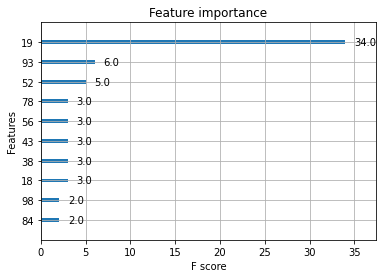

In [ ]:
xgb.plot_importance(bst,max_num_features=10)

In [ ]:
arr = np.array(column_list)
arr[[18,92,51,77,55,42,37,17],]

array(['time', 'PaCO2', 'Temp', 'MAP', 'FiO2', 'Hgb', 'BUN', 'WBC'],
      dtype='<U16')

Output the result:

In [ ]:
import xgboost as xgb
y_train = train_io["Outcome"]
dtrain = xgb.DMatrix(X_train_full, label=y_train)
dtest = xgb.DMatrix(X_test)
param = {'max_depth': 3, 'eta': 0.267, 'objective': 'binary:logistic'}
param['min_child_weight'] = 5
param['alpha'] = 0
param['lambda'] = 1
#param['gamma'] = 1
#param['tree_method'] = 'hist'
#param['subsample'] = 1
#param['colsample_bytree'] = 1
param['eval_metric'] = 'auc'
param['scale_pos_weight'] = np.sum(y_train==0)/np.sum(y_train==1)
evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 17
bst = xgb.train(param, dtrain, num_round, evallist)
y_pred = bst.predict(dtest)
k = np.array(y_val)
y_p = np.array([1 if i >= 0.5 else 0 for i in y_pred])

/usr/local/lib/python3.9/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[19:51:13] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[0]	train-auc:0.85136	eval-auc:nan
[19:51:13] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[1]	train-auc:0.87448	eval-auc:nan
[19:51:13] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[2]	train-auc:0.88769	eval-auc:nan
[19:51:13] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[3]	train-auc:0.89243	eval-auc:nan
[19:51:13] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[4]	train-auc:0.90409	eval-auc:nan
[19:51:13] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[5]	train-auc:0.90520	eval-auc:nan
[19:51:14] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[6]	train-auc

In [ ]:
print(len(y_pred),len(y_p))

6490 6490


In [ ]:
import csv
filename = "/content/test_nolabel.csv"
with open(filename, "r") as file:
    reader = csv.reader(file)
    data = list(reader)
data

In [ ]:
for i in range(6490):
  data[i+1][1]=y_p[i]
  data[i+1][2]=y_pred[i]

In [ ]:
np.array(data).shape

(6491, 3)

In [ ]:
filename = "/content/test_nolabel.csv"
with open(filename, "w", newline="") as file:
    writer = csv.writer(file)
    for row in data: 
        writer.writerow(row)

Method 2: Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression
w = {0:1, 1:7}
log_model = LogisticRegression(class_weight = w)
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_val)
sum(y_pred==y_val)/len(y_pred)
print(metrics.roc_auc_score(np.array(y_val),y_pred))
print(metrics.balanced_accuracy_score(np.array(y_val),y_pred))

0.6882646242418011
0.6882646242418011


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Method 3: Neural Network

In [ ]:
n = 21634
for i in range(1,n+1):
  k='x_all/'+str(i)+'.txt'
  p = pd.read_csv(k)
  df = df.append(p,ignore_index = True)

In [ ]:
k='x_all/'+str(1)+'.txt'
p = pd.read_csv(k)
h = np.max(p['Hour'])
col_name = p['Variable'].unique()
df = pd.DataFrame(0, index=np.arange(1,h+1), columns=col_name)
for i in range(p.shape[0]):
  df.loc[p.loc[i,'Hour'],p.loc[i,'Variable']] = p.loc[i,'Value']


In [ ]:
def transform(raw_df, column_names):
  max_len = max(raw_df.loc[:,'Hour'])
  df = pd.DataFrame(0, index = np.arange(1,max_len+1), columns = column_names)
  for j in range(raw_df.shape[0]):
    df.loc[raw_df.loc[j,'Hour'],raw_df.loc[j,'Variable']] = raw_df.loc[j,'Value']
  return df

def pad(df_list, column_names):
  tensor_list = list()
  for df in df_list:
    new_df = transform(df,column_names)
    ts = torch.tensor(new_df.values)
    tensor_list.append(ts)
  return pad_sequence(tensor_list,batch_first=True)

In [ ]:
all_X=pad(all_patients, column_names)

In [ ]:
X_train = torch.index_select(all_X,0,torch.tensor(train_index)).type(torch.float32)
X_test = torch.index_select(all_X,0,torch.tensor(train_index)).type(torch.float32)

In [ ]:
y_train = torch.tensor(y_train).type(torch.float32)

In [ ]:
i1 = list(range(0,12001))
i2 = list(range(12001,X_train.shape[0]))
X_val = torch.index_select(X_train,0,torch.tensor(i1)).type(torch.float32)
X_train = torch.index_select(X_train,0,torch.tensor(i2)).type(torch.float32)
y_val = torch.index_select(y_train,0,torch.tensor(i1)).type(torch.float32)
y_train = torch.index_select(y_train,0,torch.tensor(i2)).type(torch.float32)

In [ ]:
torch.manual_seed(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

In [ ]:
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
num_classes = 1
learning_rate = 0.001
num_epochs = 10
batch_size = 32
sequence_length = X_train.shape[1]
train = data_utils.TensorDataset(X_train, y_train)
val = data_utils.TensorDataset(X_val, y_val)

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
train_loader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=batch_size, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val,
                                           batch_size=batch_size, 
                                           shuffle=False)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        labels = labels.reshape(-1,1)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for design, labels in train_loader:
        design = design.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(design)
        predicted = (outputs>0.5).type(torch.float32)
        total += labels.size(0)
        predicted = predicted.reshape(-1)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy: {} %'.format(100 * correct / total)) 

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy: 86.36423666138404 %


In [ ]:
class NN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(NN, self).__init__()
    self.S = nn.Sequential(
        nn.LSTM(input_size, hidden_size, num_layers, batch_first=True),
        nn.dropout(0.5),
        nn.LSTM(hidden_size, 64, num_layers, batch_first=True),
        nn.dropout(0.5),
        nn.Linear(64,16),
        nn.ReLU(),
        nn.Linear(16,num_classes),
        nn.sigmoid()
    )
  def forward(self, x):
    l = self.S(x)
    return l

learning_rate = 0.001
batch_size = 32
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
num_classes = 1
num_epochs = 10
sequence_length = X_train.shape[1]
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model = NN(input_size, hidden_size, num_layers, num_classes)
train_loader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=batch_size, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val,
                                           batch_size=batch_size, 
                                           shuffle=False)

In [ ]:
train_loss = []
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    correct = 0
    t_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        t_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    t_loss /= num_batches
    train_loss.append(t_loss)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
print("Done!")
plt.plot(train_loss, label="train_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss")
plt.show()